<a href="https://colab.research.google.com/github/vmdvaldez/WeatherImageClassification/blob/master/AlexNet_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
!rm -rf /root/datasets
!mkdir /root/datasets

In [15]:
Archive('/content/drive/My Drive/Image.rar').extractall('/root/datasets')

In [16]:
!pip install split-folders

In [17]:
!pip3 install Pillow

In [18]:
!ln -s "/content/drive/My Drive/" "/bbbb"
!cp /bbbb/augment_images.sh /root
!cp /bbbb/data_augment.py /root

ln: failed to create symbolic link '/bbbb/My Drive': Operation not supported


In [19]:
!bash /root/augment_images.sh

Streaming output truncated to the last 5000 lines.
/root/datasets/Image/sunny/24885852.jpg
/root/datasets/Image/sunny/43608220.jpg
/root/datasets/Image/sunny/35324112.jpg
/root/datasets/Image/sunny/45898198.jpg
/root/datasets/Image/sunny/23818732.jpg
/root/datasets/Image/sunny/3753804.jpg
/root/datasets/Image/sunny/8926035.jpg
/root/datasets/Image/sunny/29958886.jpg
/root/datasets/Image/sunny/35089633.jpg
/root/datasets/Image/sunny/7586278.jpg
/root/datasets/Image/sunny/47779205.jpg
/root/datasets/Image/sunny/45917959.jpg
/root/datasets/Image/sunny/23211350.jpg
/root/datasets/Image/sunny/24885699.jpg
/root/datasets/Image/sunny/50587901.jpg
/root/datasets/Image/sunny/202178.jpg
/root/datasets/Image/sunny/45411741.jpg
/root/datasets/Image/sunny/22444911.jpg
/root/datasets/Image/sunny/27523324.jpg
/root/datasets/Image/sunny/19173898.jpg
/root/datasets/Image/sunny/41288677.jpg
/root/datasets/Image/sunny/49623635.jpg
/root/datasets/Image/sunny/4414311.jpg
/root/datasets/Image/sunny/8060091.

In [20]:
import time
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [21]:
import split_folders
# Put them in a ratio of 80, 10, 10 in a folder called /root/datasets/Lab_3b_Gesture_Dataset_output
split_folders.ratio('/root/datasets/Image', output="/root/datasets/Image_output", seed=1337, ratio=(.7, .15, .15)) # default values

Copying files: 33632 files [00:08, 4054.93 files/s]


In [32]:
# define training and test data directories
data_dir = '/root/datasets/Image_output'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['cloudy', 'foggy', 'rain', 'snow', 'sunny']

In [33]:
# load and transform data using ImageFolder

# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor()])


train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num test images: ', len(test_data))

Num training images:  23541
Num validation images:  5044
Num test images:  5047


In [34]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [35]:
# For getting Validation Loss

def evaluate(net, loader, criterion):
    total_loss = 0.0
    for i, data in enumerate(loader, 0):
        inputs = data
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        total_loss += loss.item()
    loss = float(total_loss) / (i + 1)
    return loss

In [36]:
def train(model, train_loader, val_loader, batch_size=36, num_epochs=30, learn_rate = 0.05):

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    iters, losses, val_loss, train_acc, val_acc = [], [], [], [], []

    # training
    print ("Training Started...")
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        curr_n = 0
        for imgs, labels in iter(train_loader):
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1
            curr_n = curr_n + 1
            print("iteration", curr_n)
        
        # track accuracy
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        val_loss.append(evaluate(model, val_loader, criterion))
        print(epoch, train_acc[-1], val_acc[-1])

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()
            
    return

In [31]:
# alexnet
import torchvision.models

alexNet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [37]:
# Save Features to Folder (assumes code from 1. has been evaluated)

import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

# location on Google Drive
train_path = '/content/drive/My Drive/Colab Notebooks/Project/Features/Train'
val_path = '/content/drive/My Drive/Colab Notebooks/Project/Features/Val'
test_path = '/content/drive/My Drive/Colab Notebooks/Project/Features/Test'

# Prepare Dataloader (requires code from 1.)
batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
classes = ['cloudy', 'foggy', 'rain', 'snow', 'sunny']

# save features to folder as tensors
n = 0
for img, label in train_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = train_path + '/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

# save features to folder as tensors
n = 0
for img, label in val_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = val_path + '/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

# save features to folder as tensors
n = 0
for img, label in test_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = test_path + '/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

In [58]:
# Load Tensor Files (features) from folder

# location on Google Drive
train_path = '/content/drive/My Drive/Colab Notebooks/Project/Features/Train'
val_path = '/content/drive/My Drive/Colab Notebooks/Project/Features/Val'
test_path = '/content/drive/My Drive/Colab Notebooks/Project/Features/Test'

#load features
# location on Google Drive
train_dataset = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
val_dataset = torchvision.datasets.DatasetFolder(val_path, loader=torch.load, extensions=('.tensor'))
test_dataset = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

# Prepare Dataloader
batch_size = 512
num_workers = 1
train_feature_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_feature_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_feature_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(train_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([512, 256, 6, 6])
torch.Size([512])


In [59]:
def get_accuracy(model, train=False):
    if train:
        data_loader = train_feature_loader
    else:
        data_loader = val_feature_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [71]:
def train2(model, train_loader, val_loader, batch_size=512, num_epochs=1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            #val_loss.append(evaluate(model, val_loader, criterion))
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    

In [65]:
torch.manual_seed(1) # set the random seed

class CNNClassifier5(nn.Module):
    def __init__(self):
        super(CNNClassifier5, self).__init__()
        self.conv1 = nn.Conv2d(256, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5*2*2, 64)
        self.fc2 = nn.Linear(64, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = x.view(-1, 5*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.22  % Time Elapsed:   8.73 s 
Iteration:  2 Progress:   0.43  % Time Elapsed:  15.69 s 
Iteration:  3 Progress:   0.65  % Time Elapsed:  22.95 s 
Iteration:  4 Progress:   0.87  % Time Elapsed:  31.15 s 
Iteration:  5 Progress:   1.09  % Time Elapsed:  38.30 s 
Iteration:  6 Progress:   1.30  % Time Elapsed:  45.66 s 
Iteration:  7 Progress:   1.52  % Time Elapsed:  53.85 s 
Iteration:  8 Progress:   1.74  % Time Elapsed:  60.69 s 
Iteration:  9 Progress:   1.96  % Time Elapsed:  67.51 s 
Iteration:  10 Progress:   2.17  % Time Elapsed:  74.32 s 
Iteration:  11 Progress:   2.39  % Time Elapsed:  81.13 s 
Iteration:  12 Progress:   2.61  % Time Elapsed:  88.04 s 
Iteration:  13 Progress:   2.83  % Time Elapsed:  95.01 s 
Iteration:  14 Progress:   3.04  % Time Elapsed:  101.95 s 
Iteration:  15 Progress:   3.26  % Time Elapsed:  108.82 s 
Iteration:  16 Progress:   3.48  % Time Elapsed:  115.69 s 
Iteration:  17 Pro

ValueError: ignored

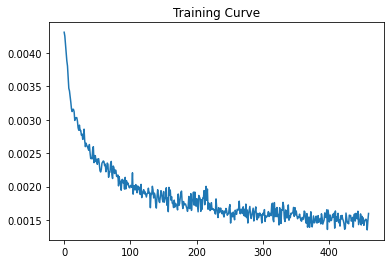

In [68]:
use_cuda = True

model =CNNClassifier5()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Prepare Dataloader
batch_size = 512
num_workers = 1
train_feature_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_feature_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_feature_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

#proper model
train2(model, train_feature_loader, val_feature_loader, num_epochs=10)

In [69]:
get_accuracy(model, train=False)

0.6802141157811261

In [70]:
get_accuracy(model, train=True)

0.7113546578310183

Iteration:  1 Progress:   0.22  % Time Elapsed:   8.30 s 
Iteration:  2 Progress:   0.43  % Time Elapsed:  14.98 s 
Iteration:  3 Progress:   0.65  % Time Elapsed:  21.60 s 
Iteration:  4 Progress:   0.87  % Time Elapsed:  28.62 s 
Iteration:  5 Progress:   1.09  % Time Elapsed:  36.11 s 
Iteration:  6 Progress:   1.30  % Time Elapsed:  42.71 s 
Iteration:  7 Progress:   1.52  % Time Elapsed:  49.38 s 
Iteration:  8 Progress:   1.74  % Time Elapsed:  56.08 s 
Iteration:  9 Progress:   1.96  % Time Elapsed:  62.80 s 
Iteration:  10 Progress:   2.17  % Time Elapsed:  69.60 s 
Iteration:  11 Progress:   2.39  % Time Elapsed:  76.31 s 
Iteration:  12 Progress:   2.61  % Time Elapsed:  83.01 s 
Iteration:  13 Progress:   2.83  % Time Elapsed:  89.73 s 
Iteration:  14 Progress:   3.04  % Time Elapsed:  96.38 s 
Iteration:  15 Progress:   3.26  % Time Elapsed:  103.00 s 
Iteration:  16 Progress:   3.48  % Time Elapsed:  109.59 s 
Iteration:  17 Progress:   3.70  % Time Elapsed:  116.26 s 
Ite

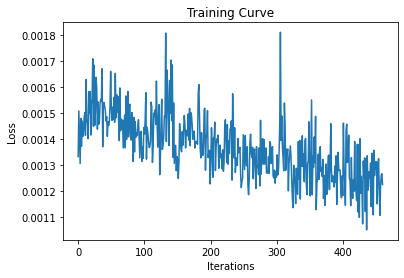

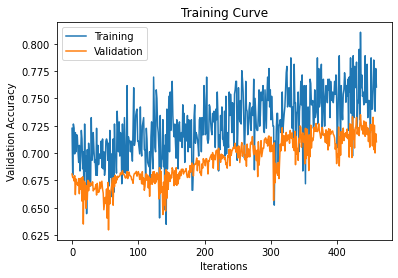

Final Training Accuracy: 0.7525168854339238
Final Validation Accuracy: 0.7103489294210944
Total time:   3156.55 s  Time per Epoch:  315.66 s 


In [72]:
train2(model, train_feature_loader, val_feature_loader, num_epochs=10)

Iteration:  1 Progress:   0.22  % Time Elapsed:   8.80 s 
Iteration:  2 Progress:   0.43  % Time Elapsed:  15.74 s 
Iteration:  3 Progress:   0.65  % Time Elapsed:  24.11 s 
Iteration:  4 Progress:   0.87  % Time Elapsed:  31.57 s 
Iteration:  5 Progress:   1.09  % Time Elapsed:  38.66 s 
Iteration:  6 Progress:   1.30  % Time Elapsed:  45.59 s 
Iteration:  7 Progress:   1.52  % Time Elapsed:  52.51 s 
Iteration:  8 Progress:   1.74  % Time Elapsed:  59.40 s 
Iteration:  9 Progress:   1.96  % Time Elapsed:  66.29 s 
Iteration:  10 Progress:   2.17  % Time Elapsed:  73.25 s 
Iteration:  11 Progress:   2.39  % Time Elapsed:  80.17 s 
Iteration:  12 Progress:   2.61  % Time Elapsed:  87.23 s 
Iteration:  13 Progress:   2.83  % Time Elapsed:  94.15 s 
Iteration:  14 Progress:   3.04  % Time Elapsed:  101.00 s 
Iteration:  15 Progress:   3.26  % Time Elapsed:  107.92 s 
Iteration:  16 Progress:   3.48  % Time Elapsed:  114.76 s 
Iteration:  17 Progress:   3.70  % Time Elapsed:  121.64 s 
It

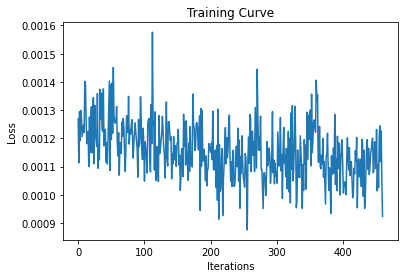

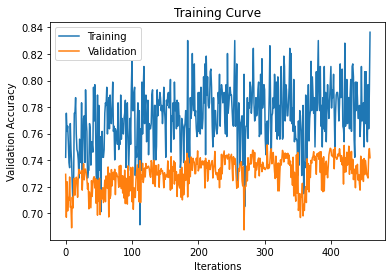

Final Training Accuracy: 0.7959305042266683
Final Validation Accuracy: 0.7418715305313244
Total time:   3236.47 s  Time per Epoch:  323.65 s 


In [73]:
train2(model, train_feature_loader, val_feature_loader, num_epochs=10)